# Visualization: using non-linear minimization to perform least-squares fit

code largely borrowed from Computer Programming course

In [467]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from GradDesc_codes.function_examples import g, grad_g, k, grad_k

Suppose that we have some non-linear function that depends on a real input x
and on some parameters a, b, c

In [468]:
def s(x, a, b, c):
    """
    sinusoidal function with parameters a, b, and c
    """
    return a + b * np.sin(c * x)

In [469]:
def e(x, a, b, c):
    """
    exponential function with parameters a, b, and c
    """
    return a + b * np.exp(c * x)

def grad_e(x, a, b, c):
    """
    gradient of the exponential function with parameters a, b, and c
    """
    return np.array([1, np.exp(c * x), b * x * np.exp(c * x)])

In [470]:
def function_wrapper(fun):
    def function(x, a, b, c):
        return fun(x, a, b, c)
    return function

In [471]:
## Choose some arbitrary "true" values for the parameters a, b, c
a_true, b_true, c_true = -0.5, 4.2, 3.5

In [472]:
f = function_wrapper(s)

Since these parameters are what we are going to try to optimize, and
since all our optimizers work on numpy arrays, we also store them
in an array, for later.
We use the letter z to denote out optimization variable, not to be
confused with x which is the input to the function `s`.

In [473]:
z_true = np.array([a_true, b_true, c_true])

## Visualizing the chosen function

First, we create a static visualization using matplotlib

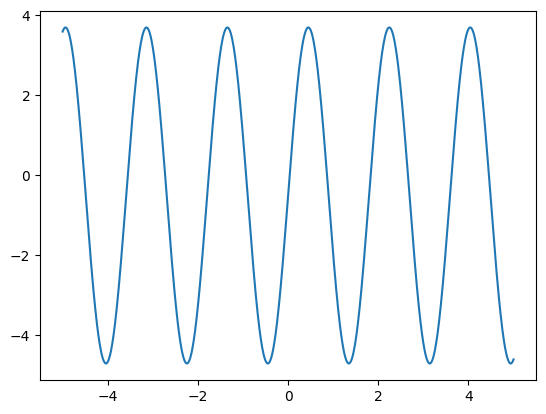

In [474]:
## Plot the true function, using a fine-grained subdivision of the x axis
## (in a realistic setting, we wouldn't have this of course)
x_fine = np.linspace(-5, 5, 1000)
y_fine = f(x_fine, a_true, b_true, c_true)
plt.clf()
plt.plot(x_fine, y_fine, '-', label="true")
plt.show()

Now, we move on to animated visualizations - as if the function is constructed little by little.

We first use matplotlibs own animation module to achieve this goal

In [475]:
# import matplotlib.animation as animation

# # Create a figure and an axis
# plt.close('all')                   # close the previous figures
# fig, ax = plt.subplots()

# # Initialize a line object that will be updated during the animation
# line, = ax.plot([], [], '-', label="true")

# # Set the limits of the plot
# ax.set_xlim(-5, 5)
# ax.set_ylim(np.min(y_fine), np.max(y_fine))

# # Initialization function for the animation
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for the animation
# def update(i):
#     line.set_data(x_fine[:i], y_fine[:i])
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(x_fine), init_func=init, blit=True)

# ani.save('function.gif', writer='Pillow', fps=30)

# plt.show()

## method 2: ipyiwidgets
Not currently working for this example. Idk why

In [476]:
# import ipywidgets as widgets
# import matplotlib.pyplot as plt

# # Define the function
# def f(t):
#     y = s(t, a_true, b_true, c_true)
#     plt.figure()
#     plt.plot(t, y, '-')
#     plt.ylim([np.min(y_fine), np.max(y_fine)])
#     plt.show()



In [477]:
# # Create the slider
# widgets.interact(f, t=widgets.FloatSlider(min=-5, max=5, step=0.1))

## Generating synthetic noisy data
  2) we pick few values of x and get the corresponding function output,
     using the true values of a, b, c
  3) we add some "noise" (random jitter) to the output values
  4) this gives us some data points (an array of x and a corresponding array
     of y)
  5) now we want to see if we can recover the original values of a, b, c by
     just knowing the data points x,y and the general shape of the function s.
     At least, we wish to get something close to the true values.

In [478]:
## Now pick some inputs (we just take them with linrange but they could be
## random or have any other form)
x_train = np.linspace(-5, 5, 60)

## Now we evaluate the output, but add some Gaussian noise to it
np.random.seed(4627323) # make the simulation reproducible
y_train = f(x_train, a_true, b_true, c_true) + 0.1 * np.random.randn(len(x_train))

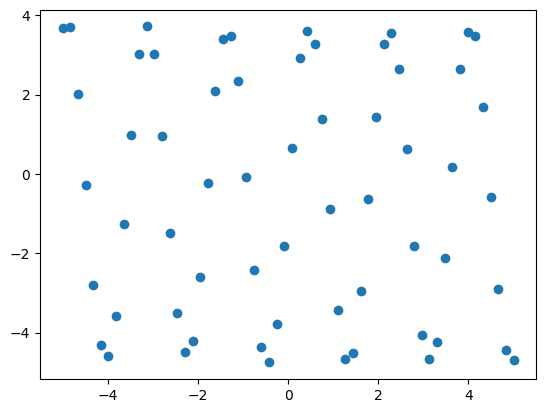

In [479]:
## Let's plot our data points
plt.plot(x_train, y_train, 'o', label="data")
plt.show()

now we want to see if we can recover the original values of a, b, c by
just knowing the data points x,y and the general shape of the function s.
At least, we wish to get something close to the true values.

We use a least squares cost function to estimate how far we are from the true values, using our costume grad_desc function (and scipy's scpiy.optimize.minimize).

Suppose that, as a preliminary step, we just guess some values of the
parameters. We can then plot the result. This works fine for visual
inspection (which isn't always possible) but it doesn't give us a way
to quantify how well we guessed, nor a well-defined way to improve the
guess.

In [480]:
## guess.
a_guess, b_guess, c_guess = 1.0, 2.0, 3.0
z_guess = np.array([a_guess, b_guess, c_guess]) # as an array, for later
y_guess = f(x_fine, a_guess, b_guess, c_guess)

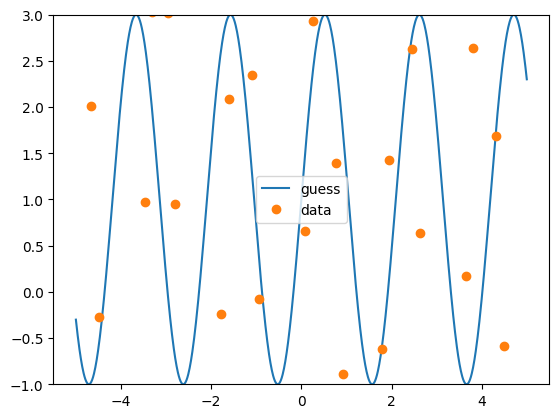

In [481]:
# plot the guess
plt.plot(x_fine, y_guess, '-', label="guess") 
plt.plot(x_train, y_train, 'o', label="data")
plt.xlim(-5.5, 5.5)
plt.ylim(-1, 3)
plt.legend()
plt.show()

Time to define the cost function then. This quantifies how well we are
guessing the true parameters.

Here we are assuming that x_data and y_data are two given arrays, and are
fixed. They are the data points.
What we are varying are the parameters a, b, c (we are trying to recover
a_true, b_true, c_true).

So we say that, for a given guess of the values a, b, c, the "cost" of an
individual pair (x_data[i], y_data[i]) is the discrepancy between the
observed value y_data[i] and the prediction based on the guess,
s(x_data[i], a, b, c).

We measure this discrepancy by taking the square of the difference (so that
it's always positive).
The overall discrepancy is the mean of all the individual discrepancies.
Exploiting as usual the broadcasting rules, all this computation reduces
to just two lines of code.

In [482]:
def loss(z, x,y):
    """
    Loss function for the exponential function.

    return: the mean squared error between the data and the model
    """
    a, b, c = z
    return np.mean((y - f(x, a, b, c))**2)

In [483]:
print(f"loss with guess: {loss(z_guess, x_train, y_train)}")
print(f"loss with true: {loss(z_true, x_train, y_train)}")

loss with guess: 11.902790099865795
loss with true: 0.012261583598989484


Now we try to find the values of a, b, c that minimize the overall discrepancy.
In other words, we try to improve on our initial guess.
This is a 3-d optimization problem.
On the other hand, x_train and y_train are our dataset and are considered fixed.

In [499]:
from GradDesc_codes.GradDescND import grad_desc
z_opt_gd, zs_gd, converged = grad_desc(lambda zz: loss(zz, x_train, y_train),
                                       z_guess,
                                       max_t = 10_000,
                                       alpha = 1e-2)
print(f"loss with g.d. opt: {loss(z_opt_gd, x_train, y_train)}")
print(f"Converged: {converged} on iteration {len(zs_gd) - 1}")


loss with g.d. opt: 0.011622835635178455
Converged: True on iteration 1425


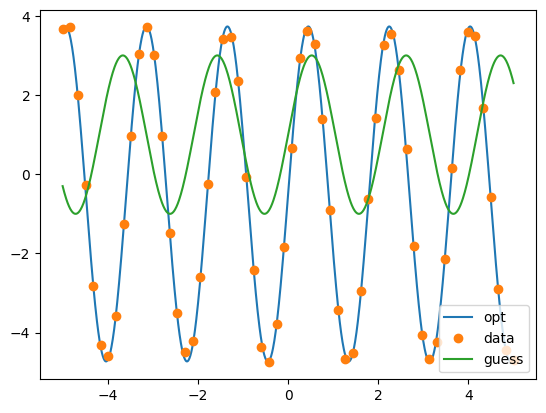

In [491]:
## Plot the function with the best-fit parameters
y_opt_gd = f(x_fine, z_opt_gd[0], z_opt_gd[1], z_opt_gd[2])
plt.plot(x_fine, y_opt_gd, '-', label="opt")
plt.plot(x_train, y_train, 'o', label="data")
plt.plot(x_fine, y_guess, '-', label="guess") 
plt.legend()

We can try to get an idea of how difficult this problem really is,
by trying to plot the optimization landscape, as we did for the
GradDescND example functions. However, this time the problem is
3-dimensional, therefore we can't really plot it. What we do instead
is fix one of the parameters to its true value, and observe how
the discrepancy changes as a function of the remaining two variables.
The plotting code is basically the same as in the test_run.py code,
and you can choose whether you prefer to see a 3-d plot or a contour
map.

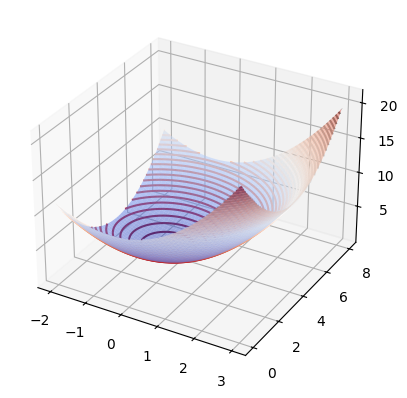

In [492]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy import newaxis as nx


fig = plt.figure()               # create a new figure
ax = plt.axes(projection='3d')    # prepare the figure to hold a 3-d plot
x0 = np.linspace(-2.0, 3.0, 100) # we'll be plotting in the interval [-2,3]x[0,8]
x1 = np.linspace(0.0, 8.0, 100)
x0, x1 = np.meshgrid(x0, x1)     # this produces two grids of points

gr = np.stack((x0, x1))          # stack the two grids together

# Note that we're fixing b=b_true and varying a and c.
h = np.mean((f(x_train[:,nx,nx], gr[0], b_true, gr[1]) - y_train[:,nx,nx])**2, axis=0)

# # If you wanted to fix a=a_true and vary b and c instead...
# h = np.sum((f(x_train[:,nx,nx], a_true, gr[0], gr[1]) - y_train[:,nx,nx])**2, axis=0)

# # If you wanted to fix c=c_true and vary a and b instead...
h = np.mean((f(x_train[:,nx,nx],gr[0], gr[1], c_true) - y_train[:,nx,nx])**2, axis = 0)

ax.plot_surface(x0, x1, h, alpha=0.5, cmap=cm.coolwarm)  # 3-d plot

# alternatively, do a contour plot: disable the `fig.gca` and `plot_surface`
# commands, and use this one instead
plt.contour(x0, x1, h, 50, cmap='RdGy')


now, coding with callback to observe the learned true values as we iterate

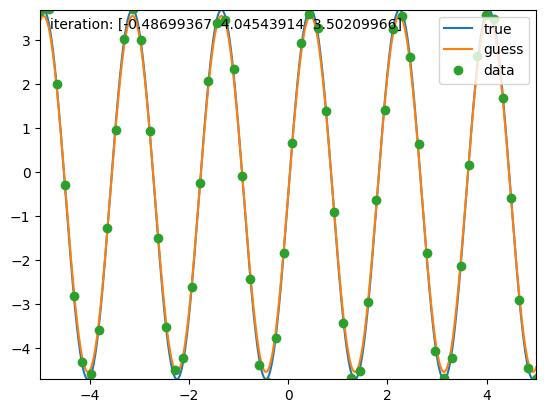

In [506]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure
fig, ax = plt.subplots()

# Initialize a line object for the true function, the guess, and the data
line_true, = ax.plot([], [], '-', label="true")
line_guess, = ax.plot([], [], '-', label="guess")
line_data, = ax.plot([], [], 'o', label="data")
# Add a label that specifies the current iteration
iteration_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)



# Set the limits of the plot
ax.set_xlim(np.min(x_fine), np.max(x_fine))
ax.set_ylim(np.min(y_fine), np.max(y_fine))

# Add a legend
ax.legend(loc = 'upper right')

# Initialization function for the animation
def init():
    line_true.set_data([], [])
    line_guess.set_data([], [])
    line_data.set_data([], [])
    return line_true, line_guess, line_data,

# Update function for the animation
def update(z):
    a, b, c = z
    y = f(x_fine, a, b, c)
    line_true.set_data(x_fine, y_fine)
    line_guess.set_data(x_fine, y)
    line_data.set_data(x_train, y_train)
    iteration_text.set_text(f'iteration: {z}')
    return line_true, line_guess, line_data, iteration_text

# Create the animation
ani = FuncAnimation(fig, update, frames=zs_gd[:250:5], init_func=init, blit=True)

# Display the animation in the Jupyter notebook
HTML(ani.to_jshtml())

In [507]:
ani.save('animation.gif', writer='pillow')